## Extracting the Dataset

In [ ]:
import zipfile
from pathlib import Path

# --- SETTINGS ---
dataset_zip = Path("dataset/PAMANA_Dataset.zip")  # top-level zip file
extract_root = Path("input/default")                      # where to unpack
extract_root.mkdir(exist_ok=True)

# --- STEP 1: Extract the top-level zip ---
print(f"Extracting: {dataset_zip}")
with zipfile.ZipFile(dataset_zip, "r") as z:
    z.extractall(extract_root)

# --- STEP 2: Recursively extract nested zips and delete them afterward ---
for inner_zip in extract_root.rglob("*.zip"):
    target_dir = inner_zip.parent / inner_zip.stem
    target_dir.mkdir(exist_ok=True)
    print(f"Extracting {inner_zip} -> {target_dir}")

    try:
        with zipfile.ZipFile(inner_zip, "r") as z:
            z.extractall(target_dir)
        inner_zip.unlink()  # delete the zip file after successful extraction
    except zipfile.BadZipFile as e:
        print(f"⚠️ Skipped bad zip {inner_zip}: {e}")

print("\n✅ All nested zips extracted and originals deleted!")

Extracting: dataset\PAMANA_Dataset.zip
Extracting input\PAMANA_Dataset\Luzon\Ab-bew_audios.zip -> input\PAMANA_Dataset\Luzon\Ab-bew_audios
Extracting input\PAMANA_Dataset\Luzon\Abistung_audios.zip -> input\PAMANA_Dataset\Luzon\Abistung_audios
Extracting input\PAMANA_Dataset\Luzon\Bangsi_audios.zip -> input\PAMANA_Dataset\Luzon\Bangsi_audios
Extracting input\PAMANA_Dataset\Luzon\Gangsa (Besao Fieldwork)_audios.zip -> input\PAMANA_Dataset\Luzon\Gangsa (Besao Fieldwork)_audios
Extracting input\PAMANA_Dataset\Luzon\Kalaleng (Besao Fieldwork)_audios.zip -> input\PAMANA_Dataset\Luzon\Kalaleng (Besao Fieldwork)_audios
Extracting input\PAMANA_Dataset\Luzon\Kalaleng (Bontoc Fieldwork)_audios.zip -> input\PAMANA_Dataset\Luzon\Kalaleng (Bontoc Fieldwork)_audios
Extracting input\PAMANA_Dataset\Luzon\Labil_audios.zip -> input\PAMANA_Dataset\Luzon\Labil_audios
Extracting input\PAMANA_Dataset\Luzon\Patang-ug_audios.zip -> input\PAMANA_Dataset\Luzon\Patang-ug_audios
Extracting input\PAMANA_Dataset\Luz

## Reading the Dataset for CSV

### Default Audio Dataset

In [14]:
import librosa
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm

# --- SETTINGS ---
DATA_DIR = Path("input/default")                 # root folder containing instrument folders
OUTPUT_CSV = "pamana_dataset.csv"
AUDIO_EXTS = {".wav", ".mp3", ".flac", ".ogg", ".m4a", ".aac", ".wma"}

# --- Feature extraction helper ---
def extract_audio_metadata(file_path: Path) -> dict | None:
    """
    Load one audio file and return basic metadata:
    sample rate, duration, file type, and inferred instrument label.
    """
    try:
        # Load audio (mono)
        y, sr = librosa.load(file_path, sr=None, mono=True)
        duration = librosa.get_duration(y=y, sr=sr)

        # Infer instrument label from parent folder (e.g., 'Agung_audios' -> 'Agung')
        parent_folder = file_path.parent.name
        instrument_label = parent_folder.replace("_audios", "")

        return {
            "filepath": str(file_path),
            "filetype": file_path.suffix.lower(),
            "sample_rate": sr,
            "duration_sec": duration,
            "instrument_label": instrument_label,
        }

    except Exception as e:
        print(f"⚠️ Skipped {file_path}: {e}")
        return None


# --- Collect all supported audio files ---
audio_files = [f for f in DATA_DIR.rglob("*") if f.suffix.lower() in AUDIO_EXTS]
print(f"Found {len(audio_files)} audio files in {DATA_DIR.resolve()}.")

# --- Extract metadata with progress bar ---
records: list[dict] = []
for f in tqdm(audio_files, desc="Extracting metadata"):
    info = extract_audio_metadata(f)
    if info:
        records.append(info)

# --- Save to CSV ---
df = pd.DataFrame(records)
if not df.empty:
    df.to_csv(OUTPUT_CSV, index=False)
    print(f"\n✅ Metadata extraction complete.")
    print(f"Saved {len(df)} rows to '{OUTPUT_CSV}'.\n")
    print("Instrument distribution:")
    print(df["instrument_label"].value_counts())
else:
    print("\n⚠️ No features extracted — check your input path and file formats.")

Found 670 audio files in C:\Users\creep\Documents\Programs\Third_Year\Project_PAMANA_dataset\input\default.


Extracting metadata: 100%|██████████| 670/670 [00:23<00:00, 28.85it/s]


✅ Metadata extraction complete.
Saved 670 rows to 'pamana_dataset.csv'.

Instrument distribution:
instrument_label
Gabbang                        70
Faglung                        54
Labil                          39
Agung (Panay Bukidnon)         34
Tumpong                        31
Subing                         30
Bombo                          28
Tambor                         26
Kubing                         24
Tambol                         24
Agung (Subanen)                24
Kalaleng (Besao Fieldwork)     24
Tacombo                        24
Tanangong                      21
Ab-bew                         20
Kalaleng (Bontoc Fieldwork)    19
Tikumbo                        18
Abistung                       17
Agung (Mansaka)                17
Gimbao                         16
Paratikan                      16
Kuging                         16
Suganggang                     11
Patik-patik                    11
Subing (Panay Bukidnon)        10
Banjo                          10


### Normalized Audio Dataset

In [ ]:
import soundfile as sf
import librosa
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import numpy as np

# === Configuration ===
REFERENCE_CSV = "pamana_dataset.csv"     # your metadata file
OUTPUT_DIR = Path("input/normalized")    # output directory
OUTPUT_DIR.mkdir(exist_ok=True)

TARGET_PEAK = 0.99  # target amplitude ceiling

# === Normalization Helper ===
def normalize_peak(audio, target_peak=0.99):
    """Peak normalization to a specified amplitude level."""
    peak = np.max(np.abs(audio))
    if peak == 0:
        return audio
    return audio * (target_peak / peak)

# === Load the metadata CSV ===
df = pd.read_csv(REFERENCE_CSV)

# === Process and Save Normalized Audio ===
for idx, row in tqdm(df.iterrows(), total=len(df), desc="Normalizing audio"):
    filepath = Path(row["filepath"])

    if not filepath.exists():
        print(f"⚠️  Missing file: {filepath}")
        continue

    try:
        # Load the file (librosa handles .mp3 and others)
        audio, sr = librosa.load(filepath, sr=None, mono=True)

        # Normalize amplitude
        norm_audio = normalize_peak(audio, TARGET_PEAK)

        # Build output file name
        output_name = filepath.stem + "_normalized.wav"
        output_path = OUTPUT_DIR / output_name

        # Save normalized file
        sf.write(output_path, norm_audio, sr)

    except Exception as e:
        print(f"❌ Error processing {filepath}: {e}")

# Save updated metadata with context labels
output_csv = "pamana_dataset_normalized.csv"
df.to_csv(output_csv, index=False)

print(f"\n✨ Done! Normalized audio saved in: {OUTPUT_DIR.resolve()}")

Normalizing audio: 100%|██████████| 670/670 [00:17<00:00, 37.25it/s]


✨ Done! Normalized audio saved in: C:\Users\creep\Documents\Programs\Third_Year\Project_PAMANA_dataset\input\normalized


AttributeError: 'str' object has no attribute 'resolve'

## Summarize the Dataset

In [ ]:
import polars as pl

default = "pamana_dataset.csv"
df = pl.read_csv(default)

df.describe()

filepath,filetype,sample_rate,duration_sec,instrument_label
str,str,i64,f64,str
"""input\PAMANA_Dataset\Visayas\T…",""".mp3""",44100,1.097143,"""Tikumbo"""
"""input\PAMANA_Dataset\Visayas\T…",""".mp3""",44100,1.149388,"""Tikumbo"""
"""input\PAMANA_Dataset\Visayas\T…",""".mp3""",44100,1.253878,"""Tikumbo"""
"""input\PAMANA_Dataset\Visayas\T…",""".mp3""",44100,1.018776,"""Tikumbo"""
"""input\PAMANA_Dataset\Visayas\T…",""".mp3""",44100,1.253878,"""Tikumbo"""


In [61]:
df.head()

,filepath,instrument_label,context_label,is_augmented,original_file,sample_rate,meta_sample_rate,duration_sec,meta_duration,rms_energy,zcr,spectral_centroid,spectral_bandwidth,rolloff,spectral_flatness,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13
0,input\PAMANA_Dataset\Luzon\Ab-bew_audios\Ab-be...,Ab-bew,ENSEMBLE,False,input\PAMANA_Dataset\Luzon\Ab-bew_audios\Ab-be...,44100,44100,64.653061,64.653061,0.164821,0.199725,5420.589395,3739.282708,9664.885713,0.004564,-91.37293,38.117980,-118.210400,8.573145,-69.512680,4.442664,-56.530598,-8.468990,-39.962215,-7.338891,-23.591326,3.966556,-7.706406
1,input\PAMANA_Dataset\Luzon\Ab-bew_audios\Ab-be...,Ab-bew,NEITHER,False,input\PAMANA_Dataset\Luzon\Ab-bew_audios\Ab-be...,44100,44100,1.123265,1.123265,0.024529,0.125136,3868.953827,3394.796648,7085.533787,0.001926,-376.71115,73.480194,-94.852104,-17.926153,-57.311337,-22.573650,-44.562187,-24.778149,-34.793903,-16.425816,-19.199139,-2.235214,-3.215138
2,input\PAMANA_Dataset\Luzon\Ab-bew_audios\Ab-be...,Ab-bew,NEITHER,False,input\PAMANA_Dataset\Luzon\Ab-bew_audios\Ab-be...,44100,44100,0.287347,0.287347,0.084633,0.223945,5939.663745,3733.703320,10099.072266,0.010475,-197.58260,22.606396,-132.932160,8.453201,-89.618256,1.758952,-65.939460,-12.376500,-45.652367,-6.580257,-20.554184,7.310105,-10.412005
3,input\PAMANA_Dataset\Luzon\Ab-bew_audios\Ab-be...,Ab-bew,NEITHER,False,input\PAMANA_Dataset\Luzon\Ab-bew_audios\Ab-be...,44100,44100,0.287347,0.287347,0.067741,0.203184,5571.882347,3821.013315,9928.529297,0.011271,-218.04716,26.683365,-135.106640,-5.861490,-84.440030,1.111929,-64.573265,-16.767828,-44.455322,-3.834105,-24.507053,11.342108,-8.733694
4,input\PAMANA_Dataset\Luzon\Ab-bew_audios\Ab-be...,Ab-bew,NEITHER,False,input\PAMANA_Dataset\Luzon\Ab-bew_audios\Ab-be...,44100,44100,0.914286,0.914286,0.023742,0.135841,4120.558923,3364.662805,7734.781077,0.001550,-356.14900,63.202156,-111.757070,-16.046595,-67.622990,-19.333677,-55.659780,-23.669556,-31.796974,-12.234386,-17.930815,2.831073,-2.453183


In [62]:
df.tail()

,filepath,instrument_label,context_label,is_augmented,original_file,sample_rate,meta_sample_rate,duration_sec,meta_duration,rms_energy,zcr,spectral_centroid,spectral_bandwidth,rolloff,spectral_flatness,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13
1045,augmented_balanced_same_dur\Tumpong\ILGN_SBN_T...,Tumpong,NEITHER,True,input\PAMANA_Dataset\Mindanao\Tumpong_audios\T...,44100,44100,0.966531,0.966531,0.051460,0.046980,2934.883476,3310.327354,6220.788574,0.053286,-520.11707,10.376930,-60.065475,-7.682974,-21.207735,-9.680672,6.930804,19.181950,31.982756,-3.876794,-23.364498,-14.731393,-3.334346
1046,augmented_balanced_same_dur\Tumpong\ILGN_SBN_T...,Tumpong,NEITHER,True,input\PAMANA_Dataset\Mindanao\Tumpong_audios\T...,44100,44100,1.306122,1.306122,0.318460,0.224622,7319.749390,6024.176931,14285.851079,0.186131,-215.13863,5.895340,-11.091962,-7.613824,-10.955503,-14.395696,-8.101527,6.032890,17.025337,14.075096,4.892373,-5.273945,-13.914377
1047,augmented_balanced_same_dur\Tumpong\ILGN_SBN_T...,Tumpong,NEITHER,True,input\PAMANA_Dataset\Mindanao\Tumpong_audios\T...,44100,44100,1.253878,1.253878,0.333703,0.157334,6935.331355,6114.701835,14705.004659,0.179461,-189.37956,11.342730,-6.932095,-9.082986,-7.383871,-11.975416,-15.632396,-11.735305,-1.031379,7.985616,14.674966,18.250204,15.688045
1048,augmented_balanced_same_dur\Tumpong\ILGN_SBN_T...,Tumpong,NEITHER,True,input\PAMANA_Dataset\Mindanao\Tumpong_audios\T...,44100,44100,0.940408,0.940408,0.088274,0.234560,8385.534189,6438.590450,16734.975229,0.207064,-265.51154,-0.574391,-16.469872,-10.895691,-4.070625,-1.133601,4.157342,10.100880,8.649016,-4.057094,-13.852189,-9.469936,2.878357
1049,augmented_balanced_same_dur\Tumpong\ILGN_SBN_T...,Tumpong,NEITHER,True,input\PAMANA_Dataset\Mindanao\Tumpong_audios\T...,44100,44100,1.149388,1.149388,0.148000,0.060015,2973.096965,3220.656286,6002.380371,0.005561,-391.98853,9.111610,-76.164870,-19.656649,-23.431622,0.642807,4.887722,16.884367,20.651152,9.192894,-11.972937,-20.850670,-8.319859


## Plotting

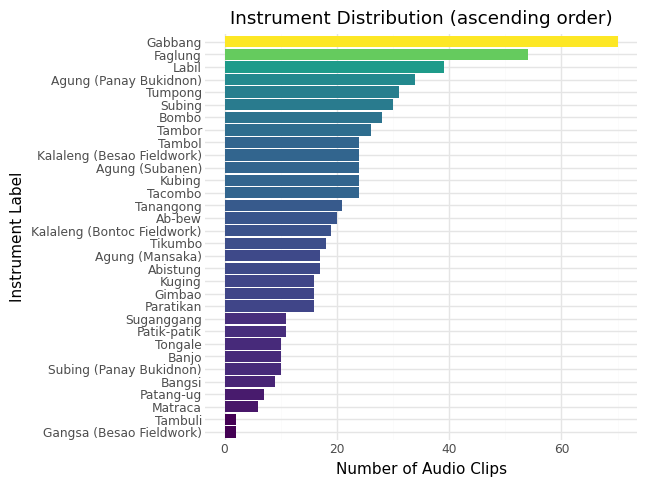

In [20]:
import pandas as pd
from plotnine import (
    ggplot, aes, geom_bar, coord_flip, labs,
    theme_minimal, scale_fill_cmap
)

# Load your metadata
df = pd.read_csv("pamana_dataset.csv")

# --- aggregate number of clips per instrument ---
counts = (
    df.groupby("instrument_label")
      .size()
      .reset_index(name="count")
      .sort_values("count", ascending=True)       # Ascending!
)

# --- preserve that order for plotting ---
counts["instrument_label"] = pd.Categorical(
    counts["instrument_label"],
    categories=counts["instrument_label"],        # order as just sorted
    ordered=True
)

# --- build the plot ---
bar_plot = (
    ggplot(counts, aes(x="instrument_label", y="count", fill="count"))
    + geom_bar(stat="identity", show_legend=False)
    + coord_flip()
    + scale_fill_cmap(name="viridis")             # nice gradient color
    + labs(
        title="Instrument Distribution (ascending order)",
        x="Instrument Label",
        y="Number of Audio Clips"
    )
    + theme_minimal()
)

bar_plot

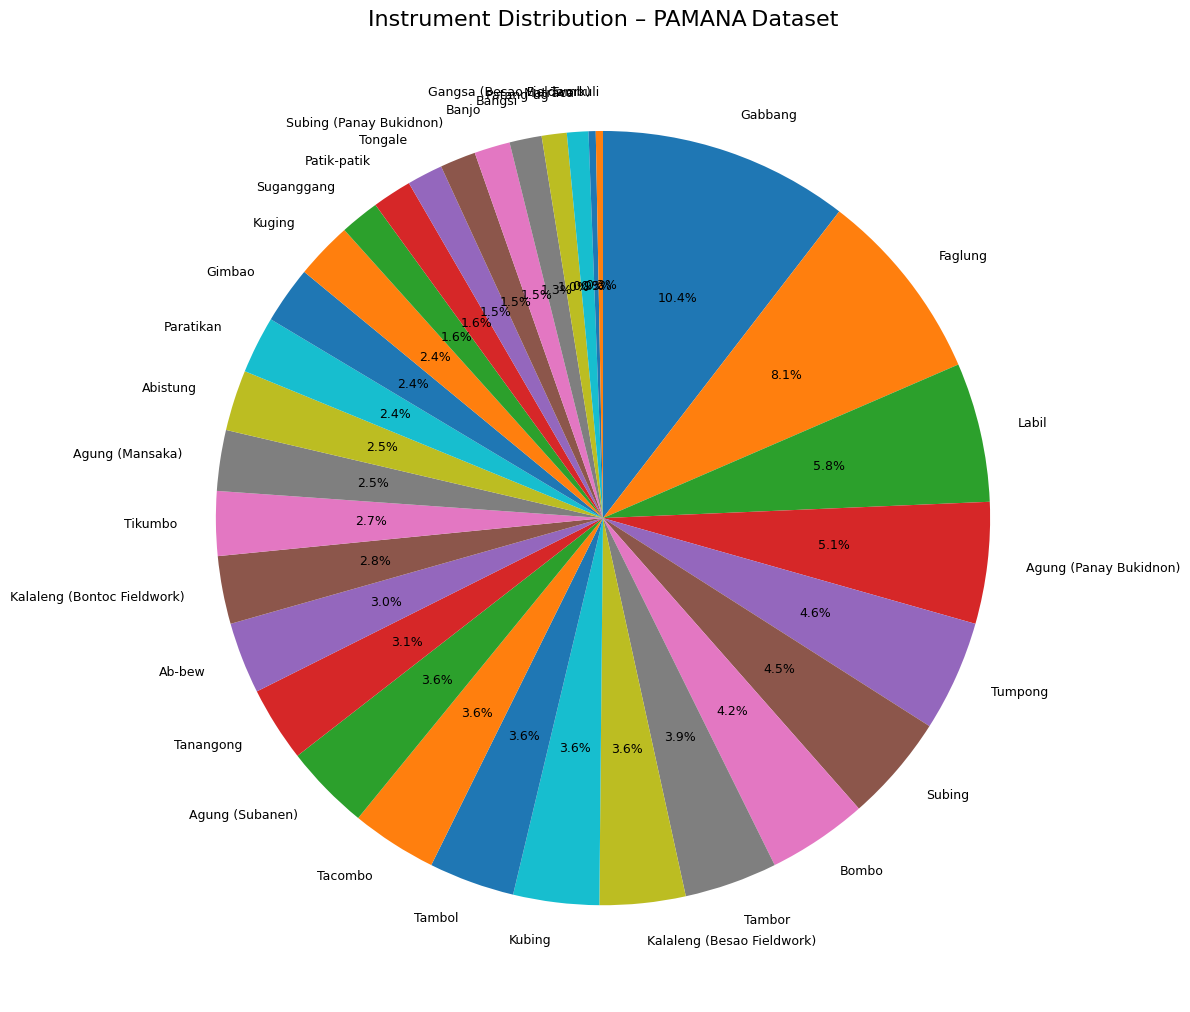

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Load and aggregate
df = pd.read_csv("pamana_dataset.csv")
counts = (
    df.groupby("instrument_label")
      .size()
      .reset_index(name="count")
      .sort_values("count", ascending=False)
)

# Make the figure larger (12 × 12 inches here)
fig, ax = plt.subplots(figsize=(12, 12))

# Pie chart
wedges, texts, autotexts = ax.pie(
    counts["count"],
    labels=counts["instrument_label"],
    autopct="%1.1f%%",
    startangle=90,
    counterclock=False,
    textprops={"fontsize": 9}          # smaller font per slice
)

ax.set_title("Instrument Distribution – PAMANA Dataset", fontsize=16)
plt.tight_layout()
plt.show()

## Preprocessing

### Data Augmentation/Balance (5 Secs)

In [ ]:
import soundfile
import pandas as pd
import random
from tqdm import tqdm
from pathlib import Path
from audiomentations import Compose, AddGaussianNoise, PitchShift, TimeStretch, Gain, Shift

# --- SETTINGS ---
REFERENCE_CSV = "pamana_dataset.csv"       # source metadata CSV
OUTPUT_DIR = Path("augmented_balanced")    # where augmented WAVs will be stored
TARGET_PER_CLASS = 70
TARGET_DURATION = 5.0                      # seconds (trim/pad clips)
OUTPUT_CSV = "pamana_balanced_5secs.csv"

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
random.seed(42)
np.random.seed(42)

# --- Augmentation pipeline ---
augmenter = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.02, p=0.8),
    PitchShift(min_semitones=-3, max_semitones=3, p=0.8),
    TimeStretch(min_rate=0.9, max_rate=1.1, p=0.8),
    Gain(min_gain_db=-6, max_gain_db=6, p=0.7),
    Shift(min_shift=-0.2, max_shift=0.2, p=0.8)
])

# --- Helper: detect 'context_label' based on filename ---
def detect_context(filename: str) -> str:
    name = filename.lower()
    if "ensemble" in name:
        return "ENSEMBLE"
    elif "piece" in name:
        return "PIECE"
    elif "modal" in name:
        return "PIECE"
    else:
        return "NEITHER"

# --- Load reference metadata ---
df = pd.read_csv(REFERENCE_CSV)
print(f"Loaded reference file list: {len(df)} records")

# --- FILTER to include only instruments with >=20 clips ---
instrument_counts = df["instrument_label"].value_counts()
valid_instruments = instrument_counts[instrument_counts >= 20].index
df = df[df["instrument_label"].isin(valid_instruments)]
print(f"Filtered instruments (>=20 samples): {list(valid_instruments)}")
print(f"Dataset after filtering: {len(df)} clips")

augmented_records = []

# --- Iterate only over those valid instruments ---
for instr, group in df.groupby("instrument_label"):
    current_n = len(group)
    needed = TARGET_PER_CLASS - current_n
    print(f"\n{instr}: {current_n} existing clips → need {max(needed, 0)} new samples")

    # Add originals
    for _, row in group.iterrows():
        context = detect_context(Path(row["filepath"]).stem)
        augmented_records.append({
            "filepath": row["filepath"],
            "instrument_label": instr,
            "context_label": context,
            "sample_rate": row.get("sample_rate", 44100),
            "duration_sec": row.get("duration_sec"),
            "is_augmented": False,
            "original_file": row["filepath"]
        })

    if needed <= 0:
        continue

    # Choose NEITHER context files for augmentation (fallback: any)
    neither_group = [
        f for f in group["filepath"].tolist()
        if detect_context(Path(f).stem) == "NEITHER"
    ]
    source_files = neither_group if neither_group else group["filepath"].tolist()
    random.shuffle(source_files)

    # Augment until each class reaches the target
    for i in tqdm(range(needed), desc=f"Augmenting {instr}"):
        src = random.choice(source_files)
        try:
            y, sr = librosa.load(src, sr=None, mono=True)
            y_aug = augmenter(samples=y, sample_rate=sr)

            # normalize to fixed length
            target_len = int(TARGET_DURATION * sr)
            if len(y_aug) > target_len:
                y_aug = y_aug[:target_len]
            elif len(y_aug) < target_len:
                y_aug = np.pad(y_aug, (0, target_len - len(y_aug)))

            # save augmented clip
            out_dir = OUTPUT_DIR / instr
            out_dir.mkdir(parents=True, exist_ok=True)
            base = Path(src).stem
            out_file = out_dir / f"{base}_aug_{i}.wav"
            soundfile.write(out_file, y_aug, sr)

            augmented_records.append({
                "filepath": str(out_file),
                "instrument_label": instr,
                "context_label": "NEITHER",  # mark all augmented as NEITHER
                "sample_rate": sr,
                "duration_sec": librosa.get_duration(y=y_aug, sr=sr),
                "is_augmented": True,
                "original_file": src
            })
        except Exception as e:
            print(f"⚠️  Skipped {src}: {e}")

# --- Save combined originals + augmentations ---
balanced_df = pd.DataFrame(augmented_records)
balanced_df.to_csv(OUTPUT_CSV, index=False)

print(f"\n✅ Balanced dataset created (≥20 instruments only). Total rows: {len(balanced_df)}")
print("Samples per instrument:")
print(balanced_df["instrument_label"].value_counts())

Loaded reference file list: 670 records
Filtered instruments (>=20 samples): ['Gabbang', 'Faglung', 'Labil', 'Agung (Panay Bukidnon)', 'Tumpong', 'Subing', 'Bombo', 'Tambor', 'Kubing', 'Tambol', 'Agung (Subanen)', 'Kalaleng (Besao Fieldwork)', 'Tacombo', 'Tanangong', 'Ab-bew']
Dataset after filtering: 473 clips

Ab-bew: 20 existing clips → need 50 new samples


Augmenting Ab-bew: 100%|██████████| 50/50 [00:16<00:00,  3.12it/s]



Agung (Panay Bukidnon): 34 existing clips → need 36 new samples


Augmenting Agung (Panay Bukidnon): 100%|██████████| 36/36 [00:03<00:00, 10.37it/s]



Agung (Subanen): 24 existing clips → need 46 new samples


Augmenting Agung (Subanen): 100%|██████████| 46/46 [00:05<00:00,  8.30it/s]



Bombo: 28 existing clips → need 42 new samples


Augmenting Bombo: 100%|██████████| 42/42 [00:02<00:00, 17.80it/s]



Faglung: 54 existing clips → need 16 new samples


Augmenting Faglung: 100%|██████████| 16/16 [00:02<00:00,  6.43it/s]



Gabbang: 70 existing clips → need 0 new samples

Kalaleng (Besao Fieldwork): 24 existing clips → need 46 new samples


Augmenting Kalaleng (Besao Fieldwork): 100%|██████████| 46/46 [00:02<00:00, 16.90it/s]



Kubing: 24 existing clips → need 46 new samples


Augmenting Kubing: 100%|██████████| 46/46 [00:02<00:00, 17.88it/s]



Labil: 39 existing clips → need 31 new samples


Augmenting Labil: 100%|██████████| 31/31 [00:01<00:00, 17.68it/s]



Subing: 30 existing clips → need 40 new samples


Augmenting Subing: 100%|██████████| 40/40 [00:01<00:00, 22.49it/s]



Tacombo: 24 existing clips → need 46 new samples


Augmenting Tacombo: 100%|██████████| 46/46 [00:01<00:00, 31.01it/s]



Tambol: 24 existing clips → need 46 new samples


Augmenting Tambol: 100%|██████████| 46/46 [00:01<00:00, 23.33it/s]



Tambor: 26 existing clips → need 44 new samples


Augmenting Tambor: 100%|██████████| 44/44 [00:01<00:00, 27.07it/s]



Tanangong: 21 existing clips → need 49 new samples


Augmenting Tanangong: 100%|██████████| 49/49 [00:02<00:00, 23.92it/s]



Tumpong: 31 existing clips → need 39 new samples


Augmenting Tumpong: 100%|██████████| 39/39 [00:01<00:00, 20.85it/s]


✅ Balanced dataset created (≥20 instruments only). Total rows: 1050
Samples per instrument:
instrument_label
Ab-bew                        70
Agung (Panay Bukidnon)        70
Agung (Subanen)               70
Bombo                         70
Faglung                       70
Gabbang                       70
Kalaleng (Besao Fieldwork)    70
Kubing                        70
Labil                         70
Subing                        70
Tacombo                       70
Tambol                        70
Tambor                        70
Tanangong                     70
Tumpong                       70
Name: count, dtype: int64


### Data Augmentation/Balance (Same Duration)

In [17]:
import librosa
import soundfile
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from pathlib import Path
from audiomentations import Compose, AddGaussianNoise, PitchShift, TimeStretch, Gain, Shift

# --- SETTINGS ---
DEFAULT = "pamana_dataset.csv"
NORMALIZED = "pamana_dataset_normalized.csv"
TARGET_PER_CLASS = 70

REFERENCE_CSV = NORMALIZED      # source metadata CSV
OUTPUT_DIR = Path("augmented/default")    # where augmented WAVs will be stored
OUTPUT_CSV = "pamana_balanced.csv"

if REFERENCE_CSV == NORMALIZED:
    OUTPUT_DIR = Path("augmented/normalized")
    OUTPUT_CSV = "pamana_balanced_normalized.csv"

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
random.seed(42)
np.random.seed(42)

# --- Augmentation pipeline ---
augmenter = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.02, p=0.8),
    PitchShift(min_semitones=-3, max_semitones=3, p=0.8),
    TimeStretch(min_rate=0.9, max_rate=1.1, p=0.8),
    Gain(min_gain_db=-6, max_gain_db=6, p=0.7),
    Shift(min_shift=-0.2, max_shift=0.2, p=0.8)
])

# --- Helper: detect 'context_label' based on filename ---
def detect_context(filename: str) -> str:
    name = filename.lower()
    if "ensemble" in name:
        return "ENSEMBLE"
    elif "piece" in name:
        return "PIECE"
    elif "modal" in name:
        return "PIECE"
    else:
        return "NEITHER"

# --- Load reference metadata ---
df = pd.read_csv(REFERENCE_CSV)
print(f"Loaded reference file list: {len(df)} records")

# --- FILTER to include only instruments with >=20 clips ---
instrument_counts = df["instrument_label"].value_counts()
valid_instruments = instrument_counts[instrument_counts >= 20].index
df = df[df["instrument_label"].isin(valid_instruments)]
print(f"Filtered instruments (>=20 samples): {list(valid_instruments)}")
print(f"Dataset after filtering: {len(df)} clips")

augmented_records = []

# --- Iterate only over those valid instruments ---
for instr, group in df.groupby("instrument_label"):
    current_n = len(group)
    needed = TARGET_PER_CLASS - current_n
    print(f"\n{instr}: {current_n} existing clips → need {max(needed, 0)} new samples")

    # Add originals
    for _, row in group.iterrows():
        context = detect_context(Path(row["filepath"]).stem)
        augmented_records.append({
            "filepath": row["filepath"],
            "instrument_label": instr,
            "context_label": context,
            "sample_rate": row.get("sample_rate", 44100),
            "duration_sec": row.get("duration_sec"),
            "is_augmented": False,
            "original_file": row["filepath"]
        })

    if needed <= 0:
        continue

    # Choose NEITHER context files for augmentation (fallback: any)
    neither_group = [
        f for f in group["filepath"].tolist()
        if detect_context(Path(f).stem) == "NEITHER"
    ]
    source_files = neither_group if neither_group else group["filepath"].tolist()
    random.shuffle(source_files)

    # Augment until each class reaches the target
    for i in tqdm(range(needed), desc=f"Augmenting {instr}"):
        src = random.choice(source_files)
        try:
            y, sr = librosa.load(src, sr=None, mono=True)
            y_aug = augmenter(samples=y, sample_rate=sr)

            # save augmented clip
            out_dir = OUTPUT_DIR / instr
            out_dir.mkdir(parents=True, exist_ok=True)
            base = Path(src).stem
            out_file = out_dir / f"{base}_aug_{i}.wav"
            soundfile.write(out_file, y_aug, sr)

            augmented_records.append({
                "filepath": str(out_file),
                "instrument_label": instr,
                "context_label": "NEITHER",  # mark all augmented as NEITHER
                "sample_rate": sr,
                "duration_sec": librosa.get_duration(y=y_aug, sr=sr),
                "is_augmented": True,
                "original_file": src
            })
        except Exception as e:
            print(f"⚠️  Skipped {src}: {e}")

# --- Save combined originals + augmentations ---
balanced_df = pd.DataFrame(augmented_records)
balanced_df.to_csv(OUTPUT_CSV, index=False)

print(f"\n✅ Balanced dataset created (≥20 instruments only). Total rows: {len(balanced_df)}")
print("Samples per instrument:")
print(balanced_df["instrument_label"].value_counts())

Loaded reference file list: 670 records
Filtered instruments (>=20 samples): ['Gabbang', 'Faglung', 'Labil', 'Agung (Panay Bukidnon)', 'Tumpong', 'Subing', 'Bombo', 'Tambor', 'Kubing', 'Tambol', 'Agung (Subanen)', 'Kalaleng (Besao Fieldwork)', 'Tacombo', 'Tanangong', 'Ab-bew']
Dataset after filtering: 473 clips

Ab-bew: 20 existing clips → need 50 new samples


Augmenting Ab-bew: 100%|██████████| 50/50 [00:01<00:00, 49.65it/s]



Agung (Panay Bukidnon): 34 existing clips → need 36 new samples


Augmenting Agung (Panay Bukidnon): 100%|██████████| 36/36 [00:03<00:00, 11.84it/s]



Agung (Subanen): 24 existing clips → need 46 new samples


Augmenting Agung (Subanen): 100%|██████████| 46/46 [00:04<00:00, 10.70it/s]



Bombo: 28 existing clips → need 42 new samples


Augmenting Bombo: 100%|██████████| 42/42 [00:01<00:00, 32.03it/s]



Faglung: 54 existing clips → need 16 new samples


Augmenting Faglung: 100%|██████████| 16/16 [00:02<00:00,  8.00it/s]



Gabbang: 70 existing clips → need 0 new samples

Kalaleng (Besao Fieldwork): 24 existing clips → need 46 new samples


Augmenting Kalaleng (Besao Fieldwork): 100%|██████████| 46/46 [00:01<00:00, 25.65it/s]



Kubing: 24 existing clips → need 46 new samples


Augmenting Kubing: 100%|██████████| 46/46 [00:01<00:00, 26.03it/s]



Labil: 39 existing clips → need 31 new samples


Augmenting Labil: 100%|██████████| 31/31 [00:01<00:00, 22.15it/s]



Subing: 30 existing clips → need 40 new samples


Augmenting Subing: 100%|██████████| 40/40 [00:01<00:00, 34.08it/s]



Tacombo: 24 existing clips → need 46 new samples


Augmenting Tacombo: 100%|██████████| 46/46 [00:00<00:00, 55.02it/s]



Tambol: 24 existing clips → need 46 new samples


Augmenting Tambol: 100%|██████████| 46/46 [00:01<00:00, 28.37it/s]



Tambor: 26 existing clips → need 44 new samples


Augmenting Tambor: 100%|██████████| 44/44 [00:01<00:00, 39.09it/s]



Tanangong: 21 existing clips → need 49 new samples


Augmenting Tanangong: 100%|██████████| 49/49 [00:01<00:00, 30.33it/s]



Tumpong: 31 existing clips → need 39 new samples


Augmenting Tumpong: 100%|██████████| 39/39 [00:01<00:00, 29.53it/s]



✅ Balanced dataset created (≥20 instruments only). Total rows: 1050
Samples per instrument:
instrument_label
Ab-bew                        70
Agung (Panay Bukidnon)        70
Agung (Subanen)               70
Bombo                         70
Faglung                       70
Gabbang                       70
Kalaleng (Besao Fieldwork)    70
Kubing                        70
Labil                         70
Subing                        70
Tacombo                       70
Tambol                        70
Tambor                        70
Tanangong                     70
Tumpong                       70
Name: count, dtype: int64


### Summarize the Context Label

In [ ]:
import pandas as pd

# --- Load your dataset ---
df = pd.read_csv("pamana_balanced.csv")   # or pamana_balanced_from_ref.csv

# --- Sanity check ---
print("Unique context labels:", df["context_label"].unique())
print("Total rows:", len(df))

# --- Count contexts per instrument ---
context_counts = (
    df.groupby(["instrument_label", "context_label"])
      .size()                                       # count rows
      .unstack(fill_value=0)                        # pivot into columns
      .sort_index()
)

# --- Add totals per instrument ---
context_counts["TOTAL"] = context_counts.sum(axis=1)

print("\nContext counts per instrument:")
print(context_counts)

# --- Optional: sort by total descending ---
print("\nSorted by total sample count:")
print(context_counts.sort_values("TOTAL", ascending=False))

# --- Optional: grand totals per context ---
print("\nGrand totals:")
print(df["context_label"].value_counts())

Unique context labels: ['ENSEMBLE' 'NEITHER' 'PIECE']
Total rows: 1050

Context counts per instrument:
context_label               ENSEMBLE  NEITHER  PIECE  TOTAL
instrument_label                                           
Ab-bew                             1       69      0     70
Agung (Panay Bukidnon)             3       60      7     70
Agung (Subanen)                    0       67      3     70
Bombo                              5       65      0     70
Faglung                            0       68      2     70
Gabbang                            0       68      2     70
Kalaleng (Besao Fieldwork)         0       67      3     70
Kubing                             0       69      1     70
Labil                              0       68      2     70
Subing                             0       70      0     70
Tacombo                            0       67      3     70
Tambol                             3       57     10     70
Tambor                             0       67      3     

### Audio Featuring

In [19]:
import pandas as pd
import librosa
import os
import numpy as np
from tqdm import tqdm

# --- SETTINGS ---
DEFAULT = "pamana_balanced.csv"
NORMALIZED = "pamana_balanced_normalized.csv"
META_CSV = DEFAULT      # metadata CSV with context/augmentation flags
OUTPUT_CSV = "pamana_features.csv"             # output file with features + metadata

if META_CSV == NORMALIZED:
    OUTPUT_CSV = "pamana_features_normalized.csv"


# --- Load metadata ---
meta_df = pd.read_csv(META_CSV)
if "filepath" not in meta_df.columns:
    raise ValueError("Your CSV must contain a 'filepath' column.")

print(f"Loaded metadata: {len(meta_df)} rows")
print("Columns found:", list(meta_df.columns))

# --- Feature extractor ---
def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=None, mono=True)

        # --- Core spectral/time features ---
        duration = librosa.get_duration(y=y, sr=sr)
        rms = np.mean(librosa.feature.rms(y=y))
        zcr = np.mean(librosa.feature.zero_crossing_rate(y=y))
        spec_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        spec_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
        rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
        flatness = np.mean(librosa.feature.spectral_flatness(y=y))

        # --- MFCCs (means only for now) ---
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_means = [np.mean(m) for m in mfccs]

        # --- Assemble dictionary ---
        feats = {
            "filepath": file_path,
            "sample_rate": sr,
            "duration_sec": duration,
            "rms_energy": rms,
            "zcr": zcr,
            "spectral_centroid": spec_centroid,
            "spectral_bandwidth": spec_bandwidth,
            "rolloff": rolloff,
            "spectral_flatness": flatness,
        }

        for i, val in enumerate(mfcc_means, start=1):
            feats[f"mfcc_{i}"] = val

        return feats

    except Exception as e:
        print(f"⚠️ Skipped {file_path}: {e}")
        return None


# --- Iterate and merge metadata ---
records = []
for _, row in tqdm(meta_df.iterrows(), total=len(meta_df), desc="Extracting audio features"):
    file_path = row["filepath"]
    feats = extract_features(file_path)
    if feats:
        # Carry over important metadata for splitting and traceability
        feats["instrument_label"] = row.get("instrument_label", "Unknown")
        feats["context_label"]   = row.get("context_label", "NEITHER")
        feats["is_augmented"]    = row.get("is_augmented", False)
        feats["original_file"]   = row.get("original_file", "")
        # Keeps duration/sample_rate consistency from metadata if present
        feats["meta_duration"]   = row.get("duration_sec", np.nan)
        feats["meta_sample_rate"]= row.get("sample_rate", np.nan)
        records.append(feats)

# --- Build final dataframe ---
features_df = pd.DataFrame(records)

# Optional: reorder columns for readability
meta_cols = ["filepath", "instrument_label", "context_label",
             "is_augmented", "original_file",
             "sample_rate", "meta_sample_rate",
             "duration_sec", "meta_duration"]
feature_cols = [c for c in features_df.columns if c not in meta_cols]
features_df = features_df[meta_cols + feature_cols]

# --- Save ---
features_df.to_csv(OUTPUT_CSV, index=False)
print(f"\n✅ Feature extraction complete.")
print(f"Saved {len(features_df)} rows to '{OUTPUT_CSV}'.")
print("Feature columns:", feature_cols[:10], "...")
print(features_df.head())

Loaded metadata: 1050 rows
Columns found: ['filepath', 'instrument_label', 'context_label', 'sample_rate', 'duration_sec', 'is_augmented', 'original_file']


Extracting audio features: 100%|██████████| 1050/1050 [01:36<00:00, 10.83it/s]


✅ Feature extraction complete.
Saved 1050 rows to 'pamana_features_normalized.csv'.
Feature columns: ['rms_energy', 'zcr', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'spectral_flatness', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4'] ...
                                            filepath instrument_label context_label  is_augmented  ...    mfcc_10    mfcc_11    mfcc_12    mfcc_13
0  input\default\PAMANA_Dataset\Luzon\Ab-bew_audi...           Ab-bew      ENSEMBLE         False  ...  -7.338891 -23.591326   3.966556  -7.706406
1  input\default\PAMANA_Dataset\Luzon\Ab-bew_audi...           Ab-bew       NEITHER         False  ... -16.425816 -19.199139  -2.235214  -3.215138
2  input\default\PAMANA_Dataset\Luzon\Ab-bew_audi...           Ab-bew       NEITHER         False  ...  -6.580257 -20.554184   7.310105 -10.412005
3  input\default\PAMANA_Dataset\Luzon\Ab-bew_audi...           Ab-bew       NEITHER         False  ...  -3.834105 -24.507053  11.342108  -8.733694
4  input\default\PAMAN

## Data Splitting

### Mark 1 (70/15/15)

In [22]:
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt

# --- Load balanced + augmented feature CSV ---
DEFAULT = "pamana_features.csv"
NORMALIZED = "pamana_features_normalized.csv"

df = pd.read_csv(NORMALIZED)
print(f"Total rows: {len(df)}")
print(df["context_label"].value_counts())

# --- Feature selection ---
exclude = ["filepath", "original_file", "instrument_label",
           "context_label", "is_augmented"]
feature_cols = [c for c in df.columns
                if c not in exclude and str(df[c].dtype) != "object"]

# --- Define groups (original file) to keep augments with parents ---
groups = df["original_file"]

# --- Base filters for each context -------------------------------
neither_df  = df[df["context_label"] == "NEITHER"]
piece_df    = df[df["context_label"] == "PIECE"]
ensemble_df = df[df["context_label"] == "ENSEMBLE"]

# --- Group‑based split for the NEITHER data (train/val/test) -----
splitter = GroupShuffleSplit(test_size=0.3, n_splits=1, random_state=42)
train_idx, temp_idx = next(splitter.split(neither_df, groups=neither_df["original_file"]))

train_df = neither_df.iloc[train_idx]
temp_df  = neither_df.iloc[temp_idx]

# Split the temporary set 50/50 → 15 % each for val/test
splitter2 = GroupShuffleSplit(test_size=0.5, n_splits=1, random_state=42)
val_idx, test_idx = next(splitter2.split(temp_df, groups=temp_df["original_file"]))
val_df_neither  = temp_df.iloc[val_idx]
test_df_neither = temp_df.iloc[test_idx]

# --- Add PIECE clips to validation and ENSEMBLE clips to test ----
val_df  = pd.concat([val_df_neither, piece_df], ignore_index=True)
test_df = pd.concat([test_df_neither, ensemble_df], ignore_index=True)

print(f"TRAIN set: {len(train_df)}   VAL set: {len(val_df)}   TEST set: {len(test_df)}")

# --- Prepare features and labels ---------------------------------
def xy_split(sub_df):
    X = sub_df[feature_cols]
    y = sub_df["instrument_label"]
    return X, y

X_train, y_train = xy_split(train_df)
X_val,   y_val   = xy_split(val_df)
X_test,  y_test  = xy_split(test_df)

# --- Scale numeric features (SVM definitely, RF optional) --------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

print("Shapes →  Train:", X_train.shape, " Val:", X_val.shape, " Test:", X_test.shape)

Total rows: 1050
context_label
NEITHER     997
PIECE        41
ENSEMBLE     12
Name: count, dtype: int64
TRAIN set: 687   VAL set: 194   TEST set: 169
Shapes →  Train: (687, 23)  Val: (194, 23)  Test: (169, 23)


### Mark 2 70/10/20

In [ ]:
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt

# --- Load balanced + augmented feature CSV ---
DEFAULT = "pamana_features.csv"
NORMALIZED = "pamana_features_normalized.csv"

df = pd.read_csv(DEFAULT)
print(f"Total rows: {len(df)}")
print(df["context_label"].value_counts())

# --- Feature selection ---
exclude = ["filepath", "original_file", "instrument_label",
           "context_label", "is_augmented"]
feature_cols = [c for c in df.columns
                if c not in exclude and str(df[c].dtype) != "object"]

# --- Define groups (original file) to keep augments with parents ---
groups = df["original_file"]

# --- Base filters for each context -------------------------------
neither_df  = df[df["context_label"] == "NEITHER"]
piece_df    = df[df["context_label"] == "PIECE"]
ensemble_df = df[df["context_label"] == "ENSEMBLE"]

# --- Group‑based split for the NEITHER data (train/val/test) -----
splitter = GroupShuffleSplit(test_size=0.3, n_splits=1, random_state=42)
train_idx, temp_idx = next(splitter.split(neither_df, groups=neither_df["original_file"]))

train_df = neither_df.iloc[train_idx]
temp_df  = neither_df.iloc[temp_idx]

# Split the temporary set 25/75
splitter2 = GroupShuffleSplit(test_size=0.75, n_splits=1, random_state=42)
val_idx, test_idx = next(splitter2.split(temp_df, groups=temp_df["original_file"]))
val_df_neither  = temp_df.iloc[val_idx]
test_df_neither = temp_df.iloc[test_idx]

# --- Add PIECE clips to validation and ENSEMBLE clips to test ----
val_df  = pd.concat([val_df_neither, piece_df], ignore_index=True)
test_df = pd.concat([test_df_neither, ensemble_df], ignore_index=True)

print(f"TRAIN set: {len(train_df)}   VAL set: {len(val_df)}   TEST set: {len(test_df)}")

# --- Prepare features and labels ---------------------------------
def xy_split(sub_df):
    X = sub_df[feature_cols]
    y = sub_df["instrument_label"]
    return X, y

X_train, y_train = xy_split(train_df)
X_val,   y_val   = xy_split(val_df)
X_test,  y_test  = xy_split(test_df)

# --- Scale numeric features (SVM definitely, RF optional) --------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

print("Shapes →  Train:", X_train.shape, " Val:", X_val.shape, " Test:", X_test.shape)

Total rows: 1050
context_label
NEITHER     997
PIECE        41
ENSEMBLE     12
Name: count, dtype: int64
TRAIN set: 687   VAL set: 113   TEST set: 250
Shapes →  Train: (687, 23)  Val: (113, 23)  Test: (250, 23)


## Models Evaluation


--- Random Forest Validation (PIECE + NEITHER original) ---
                            precision    recall  f1-score   support

                    Ab-bew       1.00      0.50      0.67        16
    Agung (Panay Bukidnon)       0.65      0.65      0.65        20
           Agung (Subanen)       0.50      0.77      0.61        13
                     Bombo       0.86      0.90      0.88        20
                   Faglung       1.00      0.73      0.84        11
                   Gabbang       0.86      0.67      0.75         9
Kalaleng (Besao Fieldwork)       0.44      0.70      0.54        10
                    Kubing       0.86      1.00      0.92         6
                     Labil       0.26      0.67      0.38         9
                    Subing       0.40      0.67      0.50         6
                   Tacombo       0.83      0.62      0.71         8
                    Tambol       1.00      0.35      0.52        20
                    Tambor       0.90      0.86      0

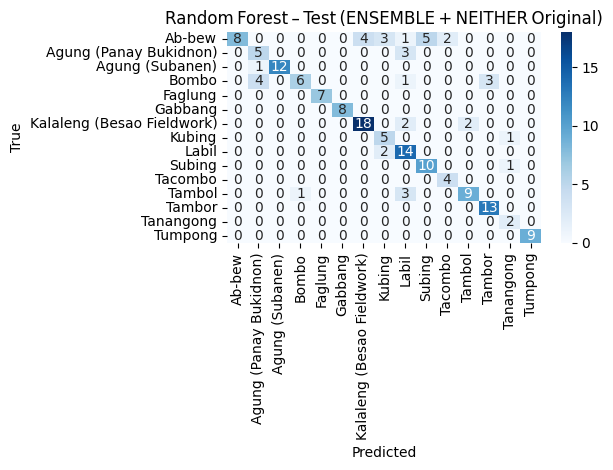

In [23]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(y_train)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

rf = RandomForestClassifier(
    n_estimators=400,
    class_weight=class_weights,
    random_state=42
)

rf.fit(X_train, y_train)

print("\n--- Random Forest Validation (PIECE + NEITHER original) ---")
print(classification_report(y_val, rf.predict(X_val)))

print("\n--- Random Forest Test (ENSEMBLE + NEITHER original) ---")
y_pred_rf_test = rf.predict(X_test)
print(classification_report(y_test, y_pred_rf_test))

sns.heatmap(confusion_matrix(y_test, y_pred_rf_test),
            annot=True, fmt="d", cmap="Blues",
            xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.title("Random Forest – Test (ENSEMBLE + NEITHER Original)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()


--- SVM Validation (PIECE + NEITHER original) ---
                            precision    recall  f1-score   support

                    Ab-bew       1.00      0.75      0.86        16
    Agung (Panay Bukidnon)       1.00      0.60      0.75        20
           Agung (Subanen)       0.83      0.77      0.80        13
                     Bombo       1.00      1.00      1.00        20
                   Faglung       0.89      0.73      0.80        11
                   Gabbang       1.00      0.78      0.88         9
Kalaleng (Besao Fieldwork)       1.00      0.70      0.82        10
                    Kubing       0.83      0.83      0.83         6
                     Labil       1.00      0.78      0.88         9
                    Subing       0.80      0.67      0.73         6
                   Tacombo       0.56      0.62      0.59         8
                    Tambol       0.91      0.50      0.65        20
                    Tambor       1.00      0.86      0.92       

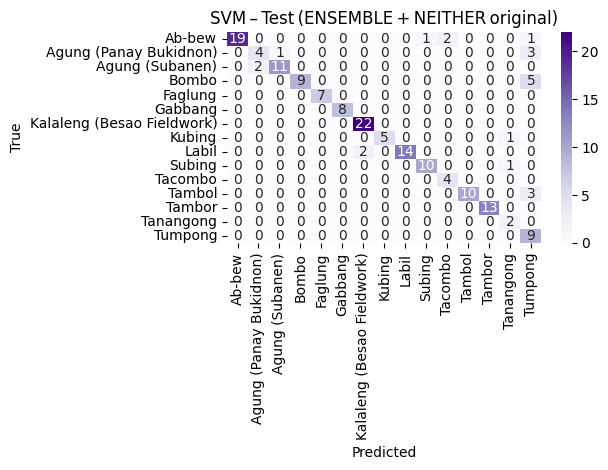

In [24]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- Fit an SVM on your scaled features ---
svm = SVC(
    kernel="rbf",
    C=10,                # start here; tune later
    gamma="scale",
    class_weight="balanced",
    probability=True,
    random_state=42
)

svm.fit(X_train_scaled, y_train)

# --- Validation on PIECE + NEITHER originals ---
y_val_pred = svm.predict(X_val_scaled)
print("\n--- SVM Validation (PIECE + NEITHER original) ---")
print(classification_report(y_val, y_val_pred))

# --- Test on ENSEMBLE + NEITHER originals ---
y_test_pred = svm.predict(X_test_scaled)
print("\n--- SVM Test (ENSEMBLE + NEITHER original) ---")
print(classification_report(y_test, y_test_pred))

# --- Confusion matrix for test ---
cm = confusion_matrix(y_test, y_test_pred, labels=svm.classes_)
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
            xticklabels=svm.classes_, yticklabels=svm.classes_)
plt.title("SVM – Test (ENSEMBLE + NEITHER original)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

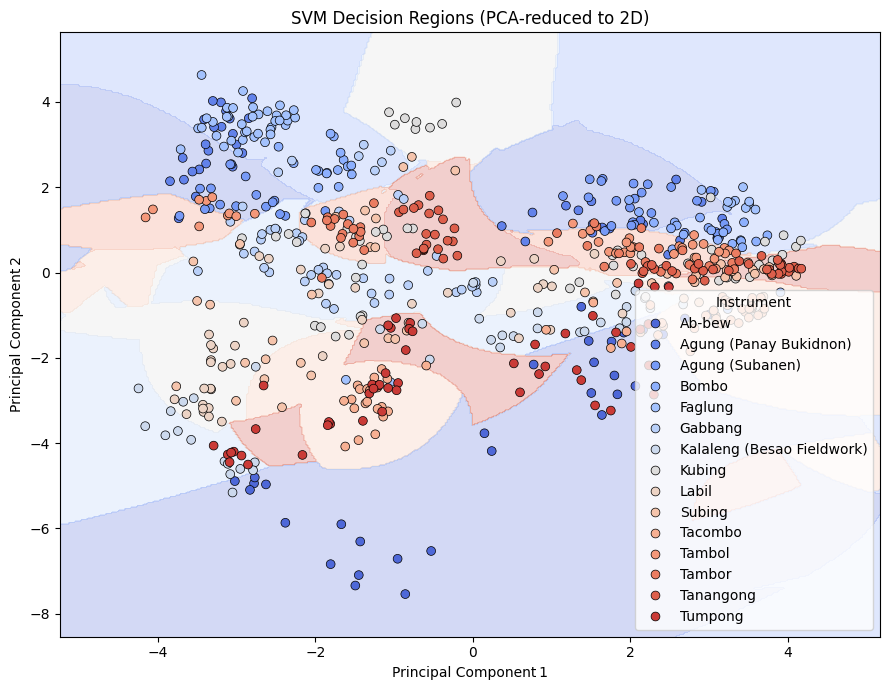

In [28]:
from sklearn.decomposition import PCA
import numpy as np

# --- 2D PCA projection for visualization ---
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
y_train_pca = y_train

# Refit an SVM on just these 2D coordinates (for a visible boundary)
svm_vis = SVC(kernel="rbf", C=10, gamma="scale", class_weight="balanced")
svm_vis.fit(X_train_pca, y_train_pca)

# --- Mesh grid for decision boundary ---
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 400),
    np.linspace(y_min, y_max, 400)
)
Z = svm_vis.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# Map your classes to integer codes for coloring
from sklearn.preprocessing import LabelEncoder
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

le = LabelEncoder()
le.fit(y_train_pca)

Z = svm_vis.predict(np.c_[xx.ravel(), yy.ravel()])
Z_num = le.transform(Z)               # encode string labels → numbers
Z_num = Z_num.reshape(xx.shape)

plt.figure(figsize=(9, 7))
plt.contourf(xx, yy, Z_num, alpha=0.25, cmap="coolwarm")

# Scatter plot using same numeric color mapping
sns.scatterplot(
    x=X_train_pca[:, 0],
    y=X_train_pca[:, 1],
    hue=y_train_pca,
    palette="coolwarm",
    edgecolor="k",
    s=40
)
plt.title("SVM Decision Regions (PCA‑reduced to 2D)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Instrument", loc="best")
plt.tight_layout()
plt.show()